<a href="https://colab.research.google.com/github/mdzafri/uniten-ai/blob/main/YOLOv5_Pre_trained_Model_Inferencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#YOLOv5 Inferencing & Re-Training Project

*   This script is adapted from the **official YOLOv5 🚀 notebook** by **Ultralytics**, and is available for redistribution under the [GPL-3.0 license](https://choosealicense.com/licenses/gpl-3.0/). 
For more information please visit https://github.com/ultralytics/yolov5 and https://ultralytics.com. 

*   Webcam codes were modified from [Real-time YOLOv4 Object Detection on Webcam in Google Colab](https://www.youtube.com/watch?v=ebAykr9YZ30) by [the AI guy](https://www.youtube.com/c/TheAIGuy/videos)

# 1 Setup

Clone repo, install dependencies and check PyTorch and GPU.

RUN THIS CELL ONLY **ONE TIME** PER SESSION.

In [ ]:
# I REPEAT: RUN THIS CELL ONLY ONE TIME PER SESSION!   <-----------------
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

from yolov5 import utils
display = utils.notebook_init()  # checks

# 2 Inference on Images in data/images Folder

Try performing inference on image or video files.

## 2.1 How to use `detect.py`

`detect.py` is a Python script that simplifies the use of YOLOv5.

Variables you can choose to pass to the `detect.py` script.

`--weights`: State the model to be used. I chose the `yolov5s.pt` model. This will download models automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases).

`--img`: Model input size. Check [releases](https://github.com/ultralytics/yolov5/releases) to use the correct input size. 

`--conf`: The minimum confidence threshold value to display.

`--source`: Provide a path to a file or folder containing images or video for inferencing. YOLOv5 can infer a variety of image & video file formats. 

Example inference sources are:

```shell
python detect.py --source 0  # webcam
                          img.jpg  # image 
                          vid.mp4  # video
                          path/  # directory
                          path/*.jpg  # glob
                          'https://youtu.be/Zgi9g1ksQHc'  # YouTube
                          'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```

Modify/run the following cell to run the `detect.py` script to infer files in the `data/images` folder. 

Results are saved to `runs/detect`. 

In [ ]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images

## 2.2 Run `detect.py`

Run the following cell to display all images in the `runs/detect/exp` folder. 

Depending on how many times you ran the `detect.py` script, you may have to edit the `exp#` string.

In [ ]:
#display all infered images
import glob
from IPython.display import Image, display
# may have to edit the..
# exp string path ──────┐
imgPath = 'runs/detect/exp'

for imageName in glob.glob(imgPath + '/*.png'): #assuming PNG
    display(Image(filename=imageName))
    print("\n")
for imageName in glob.glob(imgPath + '/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# 3 Inference on Webcam Images & Video

Apply inferencing directly on your webcam.


Modify the `weights` string to point to the YOLOv5 model of your choice. Even a custom trained model!

In [5]:
# Use a pretrained model
weights = 'yolov5s.pt'

# Use a custom model
# weights = 'runs/train/exp/weights/best.pt'

## 3.1 Helper Functions
Helper Functions are additional functions that help to prepare data for input and output to the AI model in the correct format. Here are helper functions that use a webcam as input to take pictures and live video.

You can safely run these cells without modification.

In [6]:
# import dependencies and YOLOv5 functions to perform object detections
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
import sys
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn

from models.common import DetectMultiBackend
from utils.augmentations import letterbox
from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync

In [7]:
imgsz = [640, 640]
conf_thres = 0.25
iou_thres = 0.45
classes = None
agnostic_nms = False
hide_labels = False
hide_conf = False
show_text_output = True
max_det = 1000
device = select_device('')
model = DetectMultiBackend(weights, device=device, dnn=False)
stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
imgsz = check_img_size(imgsz, s=stride)  # check image size

model.warmup(imgsz=(1, 3, *imgsz))  # warmup

YOLOv5 🚀 v6.0-207-g8efe977 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients


In [8]:
# YOLOv5 helper function to run detection on image
def yolo_helper(im0):
    dt, seen = [0.0, 0.0, 0.0], 0
    s = ''
    # Dataloader
    # im0 = cv2.flip(im0, 1)  # flip left-right
    im = letterbox(im0, imgsz, stride=stride)[0] # padded resize
    im = im.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    im = np.ascontiguousarray(im)

    # Run inference
    t1 = time_sync()
    im = torch.from_numpy(im).to(device)
    im = im.float()  # uint8 to fp16/32
    im /= 255  # 0 - 255 to 0.0 - 1.0
    if len(im.shape) == 3:
        im = im[None]  # expand for batch dim
    t2 = time_sync()
    dt[0] += t2 - t1
    
    # Inference
    pred = model(im, augment=False, visualize=False)
    t3 = time_sync()
    dt[1] += t3 - t2

    # NMS
    pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
    dt[2] += time_sync() - t3

    # Process predictions
    for i, det in enumerate(pred):  # per image
        seen += 1
        
        annotator = Annotator(im0, line_width=3, example=str(names))
        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(im.shape[2:], det[:, :4], im0.shape).round()

            # Print results
            for c in det[:, -1].unique():
                n = (det[:, -1] == c).sum()  # detections per class
                s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

            # Write results
            for *xyxy, conf, cls in reversed(det):
                c = int(cls)  # integer class
                label = None if hide_labels else (names[c] if hide_conf else f'{names[c]} {conf:.2f}')
                annotator.box_label(xyxy, label, color=colors(c, True))

        # Print time (inference-only)
        if show_text_output == True:
            LOGGER.info(f'{s}Done. ({t3 - t2:.3f}s)')

    # Print results
    if show_text_output == True:
        t = tuple(x / seen * 1E3 for x in dt)  # speeds per image
        LOGGER.info(f'Speed: %.1fms pre-process, %.1fms inference, %.1fms NMS per image at shape {(1, 3, *imgsz)}' % t)

    return pred[0]

In [9]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## 3.2 YOLOv5 on a Webcam Image
Running YOLOv5 on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** which runs JavaScript code to utilize your computer's webcam. The code snippet will take a webcam photo, which we will then pass into our YOLOv5 model for object detection.

Below is a function to take the webcam picture using JavaScript and then run YOLOv5 on it.

### Helper function to access webcam

In [10]:
# Javascript function to access the webcam. Please allow access to the camera.
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture Photo';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      video.msHorizontalMirror = true;
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 

  # save image
  cv2.imwrite(filename, img)

  # call our yolo helper on webcam 
  detections = yolo_helper(img)

  # loop through detections and draw them on webcam image
  # for x1, y1, x2, y2, conf, cls in detections:
  #   c = int(cls)  # integer class
  #   left, top, right, bottom = int(x1), int(y1), int(x2), int(y2)
  #   cv2.rectangle(img, (left, top), (right, bottom), colors(c, True), 3)
  #   cv2.putText(img, "{} [{:.2f}]".format(names[c], float(conf)),
  #                     (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
  #                     colors(c, True), 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

### Turn on the webcam and take a picture

<IPython.core.display.Javascript object>

1 person, 1 tie, 1 cup, 1 fork, Done. (0.032s)
Speed: 0.7ms pre-process, 31.9ms inference, 1.8ms NMS per image at shape (1, 3, 640, 640)


Saved to photo.jpg


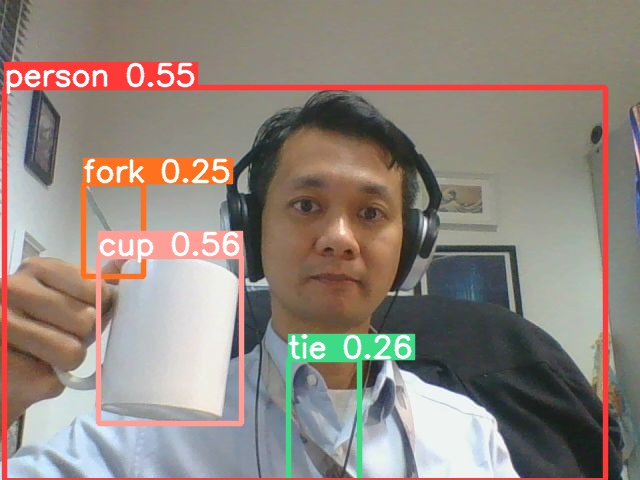

In [11]:
# Turn on the webcam and take a picture
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## 3.3 YOLOv5 on Webcam Videos
Running YOLOv5 on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our YOLOv5 model and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream. 

YOLOv5 is so fast that it can run the detections in real-time!

(The picture says v4, just imagine it says v5)

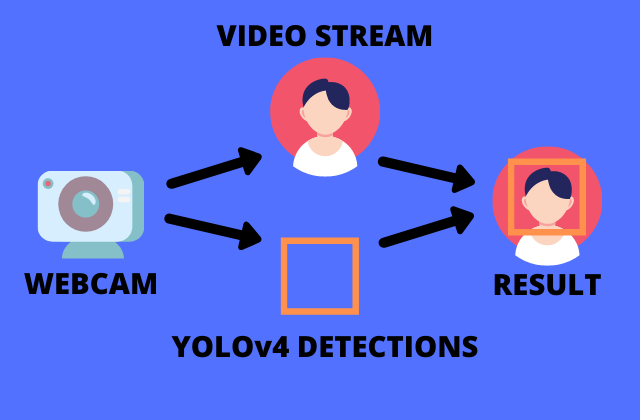

Below is a function to start up the video stream using similar JavaScript as was used for images. The video stream frames are fed as input to YOLOv5.

### More helper functions for webcam stream

In [12]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Send Webcam Video Stream to YOLOv5

In [13]:
# start streaming video from webcam
video_stream()
# label for video
show_text_output = False
label_html = 'Inferencing... [Click the video to stop inferencing]'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our yolo helper on webcam 
    detections = yolo_helper(frame)

    # loop through detections and draw them on a transparent overlay image
    for x1, y1, x2, y2, conf, cls in detections:
      c = int(cls)  # integer class
      left, top, right, bottom = int(x1), int(y1), int(x2), int(y2)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), colors(c, True), 3)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(names[c], float(conf)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        colors(c, True), 3)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>